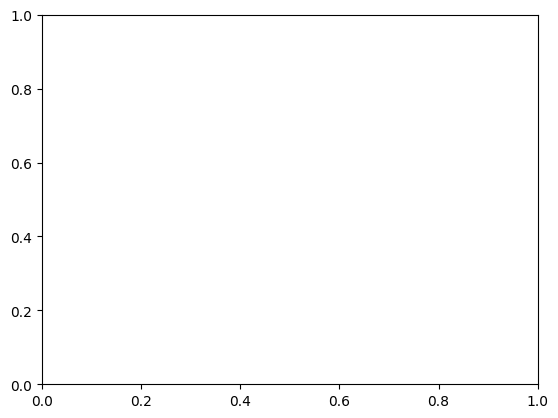

In [2]:
# Imports
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tkinter as tk
import math
import numpy as np
from tkinter import filedialog
from scipy.signal import filtfilt, butter
from torque_log_analysis import resample_data,drop_rows_from_df
import os
plt.style.use('bmh')


In [3]:


# Create the Tkinter root widget
# root = tk.Tk()
# root.withdraw()  # Hide the main window

# # Ask the user to select a file
# dyno_file_path = filedialog.askopenfilename(
#     title="Select the dyno run .txt file",
#     filetypes=[("All files", "*.*")],
#     initialdir="/",
#     message="Please select the dyno run .txt."
# )
# # Ask the user to select a file
# car_log_file_path = filedialog.askopenfilename(
#     title="Select the car log .csv file",
#     filetypes=[("All files", "*.*")],
#     initialdir="/",
#     message="Please select the car log csv."
# )
# dyno_file_path
# create list of tuple of dyno log filepath and car log filepath
log_paths = [
    ("4-26-23_power_run.txt",r"C:\Users\Matthew Samson\Documents\formula\4-26-2023_dyno_and_regen\parsed-data\parseddata0003.CSV"), # 0
    (r"C:\Users\Matthew Samson\source\repos\KS5e-Data-Logging\emrax228HVweakAssDynoRun.txt",r"C:\Users\Matthew Samson\Documents\formula\228hv\parsed-data\parsedMDY_3-3-2024_HMS_3-58-56.CSV"), # 1
    ("asdf",r"C:\Users\Matthew Samson\Documents\formula\228hv\parsed-data\parsedMDY_3-3-2024_HMS_4-11-35.CSV") # need to find the right dyno log for this day 
]
log_index = 0


In [4]:
# # Reformat fucked up dyno logs
# with open('dynoruns\DJDataExport_DYNORUN_015.txt', 'r') as file:
# # Read the file
#     lines = file.readlines()

# # Remove leading and trailing spaces, split columns, and exclude lines with 'N/A'
# formatted_lines = [line.strip().split() for line in lines if 'N/A' not in line]

# # Reformat the lines with tab delimiter
# formatted_text = '\n'.join([' '.join(line) for line in formatted_lines])

# # Write the reformatted text back to the file
# with open('your_file_reformatted.txt', 'w') as file:
#     file.write(formatted_text)

# This code is to reformat fucked up dyno logs if necessary



In [5]:
# Calculate some constants 
MOTOR_KT = 0.94
gear_tooth_count_motor = 10  # KS6e front sprocket
gear_tooth_count_wheel = 30  # KS6e rear sprocket

dyno_tire_diameter = 20.5 # ish inches 
# tire_dims = [18,19,20]
tire_dims = []
normal_tire_diameter = 18 # ish inches
tire_diameter = normal_tire_diameter # set to the right tire size when plotting

gear_ratio = gear_tooth_count_wheel / gear_tooth_count_motor

# Calculate wheel circumference
wheel_circumference = tire_diameter * 3.141592653589793  # Pi
wheel_circums_varied = []
for dim in tire_dims:
    wheel_circums_varied.append(dim*3.141592653589793)
wheel_circums_varied


[]

In [6]:
# open dyno run file
dynofile = (os.path.basename(log_paths[log_index][0]))
dyno_run_df = pd.read_csv(log_paths[log_index][0],delimiter=" ")
# drop shit rows
dynorun = dyno_run_df[dyno_run_df["s"]>=0]
# dynorun = dyno_run_df[dyno_run_df["hp"]>=0]
dynorun=dynorun[['s','hp','mph']]
del(dyno_run_df)
dynorun["dyno_kw"] = dynorun['hp']/1.341 # add KW column
dynorun["wheel_rpm"] = dynorun["mph"] / ((wheel_circumference * 60)/63360 )
list_of_varied_dims_rpms=[]
for index,circum in enumerate(tire_dims):
    name = "wheel_rpm_"+str(circum)
    dynorun[name] = dynorun["mph"] / ((circum * 3.141592653589793 * 60)/63360 )
    list_of_varied_dims_rpms.append(name)
    
print(list_of_varied_dims_rpms)
dynorun["wheel_torque"] = (9548.8 * dynorun["dyno_kw"])/dynorun["wheel_rpm"]

list_of_varied_wtrq = []
for index,rpm in enumerate(list_of_varied_dims_rpms):
    wtrqname = "wheel_torque_"+str(tire_dims[index])
    dynorun[wtrqname]=(9548.8 * dynorun["dyno_kw"])/dynorun[rpm]
    list_of_varied_wtrq.append(wtrqname)
    
dynorun["motor_rpm"]=dynorun["wheel_rpm"]*gear_ratio

for index,rpm in enumerate(list_of_varied_dims_rpms):
    colname = "motor_rpm_" +str(tire_dims[index])
    dynorun[colname]=dynorun[rpm]*gear_ratio
    
dynorun["motor_torque"] = dynorun["wheel_torque"] / gear_ratio

for index,trq in enumerate(list_of_varied_wtrq):
    colname = "motor_torque_" +str(tire_dims[index])
    dynorun[colname]=dynorun[trq]/gear_ratio
    
print("dynorun MAXES:")
dynorun.max()

[]
dynorun MAXES:


s                 16.620000
hp                69.030000
mph              110.500000
dyno_kw           51.476510
wheel_rpm       2063.496889
wheel_torque     582.508514
motor_rpm       6190.490667
motor_torque     194.169505
dtype: float64

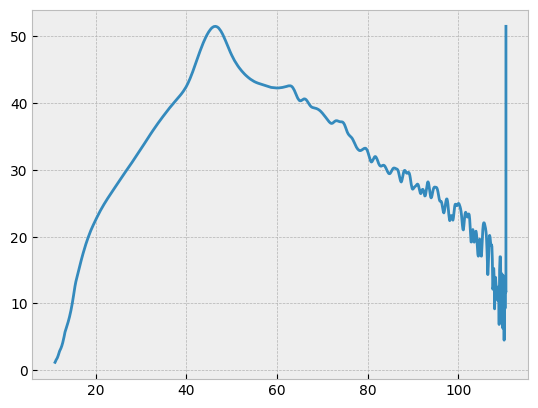

In [7]:
# plot dyno stuff
plt.plot(dynorun['mph'],dynorun['dyno_kw'])
plt.show()

In [8]:

# load electrical log
carfile = (os.path.basename(log_paths[log_index][1]))

vehicle_log = pd.read_csv(log_paths[log_index][1])

# remove df cols we dont care about
car_log_cols_to_keep = [
    "Time", "D1_Commanded_Torque", "D2_Torque_Feedback", "D2_Motor_Speed",
    "Pack_Current", "Pack_Inst_Voltage", "D4_Iq", "D3_Id",
    "D2_Output_Voltage", "D3_VAB_Vd_Voltage", "D4_VBC_Vq_Voltage",
    "D1_DC_Bus_Voltage","D4_DC_Bus_Current",
    "D1_Motor_Angle_Electrical",'D2_Flux_Weakening_Output']

vehicle_log = vehicle_log[car_log_cols_to_keep]

# cancer time
vehicle_log = resample_data(vehicle_log, "Time", plots_to_compare=False)
vehicle_log = drop_rows_from_df(vehicle_log,"D1_Commanded_Torque",1,400)


vehicle_log = drop_rows_from_df(vehicle_log, "D2_Motor_Speed", 10, 7000)

# get a power column to compare with dyno
vehicle_log["kw"] = vehicle_log["Pack_Current"] * \
    vehicle_log["Pack_Inst_Voltage"] / 1000

# Define the filter
order = 2
fs = 1 / (10 / 1000)  # Sampling frequency
nyquist = fs / 2
cutoff = min(0.5 * nyquist, 100)  # Desired cutoff frequency of the filter (Hz)
print(str(cutoff)+"Hz")
b, a = butter(order, cutoff / (fs / 2), btype='low')

# Apply filtfilt to the 'Value' column
vehicle_log['smooth_trq'] = filtfilt(b, a, vehicle_log['D2_Torque_Feedback'])
vehicle_log["acc_kw"] = filtfilt(b, a, vehicle_log['kw'])
vehicle_log["smooth_rpm"] = filtfilt(b, a, vehicle_log['D2_Motor_Speed'])
vehicle_log["smooth_iq"] = filtfilt(b, a, vehicle_log['D4_Iq'])
vehicle_log["smooth_id"] = filtfilt(b, a, vehicle_log['D3_Id'])
vehicle_log["smooth_outputvoltage"] = filtfilt(
    b, a, vehicle_log['D2_Output_Voltage'])
vehicle_log["smooth_vq"] = filtfilt(b, a, vehicle_log['D4_VBC_Vq_Voltage'])
vehicle_log['smooth_vd'] = filtfilt(b, a, vehicle_log['D3_VAB_Vd_Voltage'])
vehicle_log['smooth_dcbusvoltage'] = filtfilt(b, a, vehicle_log['D1_DC_Bus_Voltage'])
vehicle_log['smooth_dcbuscurrent'] = filtfilt(b, a, vehicle_log['D4_DC_Bus_Current'])
vehicle_log['calc_motor_torque'] = (vehicle_log['smooth_iq'] / (math.sqrt(2))) * MOTOR_KT
vehicle_log['inverter_pwr_kw'] = vehicle_log['smooth_dcbusvoltage'] * vehicle_log['smooth_dcbuscurrent'] / 1000
# calculate total motor current
vehicle_log["motor_current"] = (
    vehicle_log["smooth_id"] ** 2 + vehicle_log["smooth_iq"] ** 2).pow(1/2)
vehicle_log["motor_power"] = vehicle_log['motor_current'] * vehicle_log['smooth_outputvoltage'] / 1000
# power factor
power_factor = 1.0
vehicle_log["chatgpt_power"] = (vehicle_log['smooth_vd'] * vehicle_log['smooth_id'] +
                                vehicle_log['smooth_vq'] * vehicle_log['smooth_iq'])/power_factor/1000
vehicle_log['torque_feedback_pwr_kw'] = vehicle_log['smooth_trq'] * vehicle_log['smooth_rpm'] / 9548.8
vehicle_log['motor_power_kt_calc'] = vehicle_log["calc_motor_torque"] * vehicle_log['smooth_rpm'] / 9548.8
vehicle_log.min()

2024-03-26 16:06:05,268 [INFO] torque_log_analysis.py:45: D1_Commanded_Torque: dropped 38842 rows
2024-03-26 16:06:05,273 [INFO] torque_log_analysis.py:45: D2_Motor_Speed: dropped 185 rows


25.0Hz


D1_Commanded_Torque            1.000000
D2_Torque_Feedback           -39.700000
D2_Motor_Speed                10.140351
Pack_Current                  -8.534286
Pack_Inst_Voltage            201.200000
D4_Iq                        -52.850000
D3_Id                       -316.900000
D2_Output_Voltage              0.700000
D3_VAB_Vd_Voltage           -145.300000
D4_VBC_Vq_Voltage            -60.507692
D1_DC_Bus_Voltage            191.337500
D4_DC_Bus_Current             -0.633333
D1_Motor_Angle_Electrical      3.600000
D2_Flux_Weakening_Output    -510.906452
kw                            -2.272229
smooth_trq                   -42.787884
acc_kw                        -2.318622
smooth_rpm                  -250.140901
smooth_iq                    -53.653550
smooth_id                   -320.831070
smooth_outputvoltage          -4.822493
smooth_vq                    -61.932952
smooth_vd                   -145.616830
smooth_dcbusvoltage          191.249119
smooth_dcbuscurrent           -2.999095


In [9]:
path = r"C:\Users\Matthew Samson\Documents\formula\4-26-2023_dyno_and_regen\parsed-data\parseddata0003.CSV"
testlog = pd.read_csv(path)
print(list(testlog))

['Time', 'D1_Modulation_Index', 'D2_Flux_Weakening_Output', 'D3_Id_Command', 'D4_Iq_Command', 'D1_Phase_A_Current', 'D2_Phase_B_Current', 'D3_Phase_C_Current', 'D4_DC_Bus_Current', 'D1_Motor_Angle_Electrical', 'D2_Motor_Speed', 'D3_Electrical_Output_Frequency', 'D4_Delta_Resolver_Filtered', 'D1_VSM_State', 'D2_Inverter_State', 'D3_Relay_1_Status', 'D3_Relay_2_Status', 'D3_Relay_3_Status', 'D3_Relay_4_Status', 'D3_Relay_5_Status', 'D3_Relay_6_Status', 'D4_Inverter_Run_Mode', 'D4_Inverter_Discharge_State', 'D5_Inverter_Command_Mode', 'D6_Inverter_Enable_State', 'D6_Inverter_Enable_Lockout', 'D7_Direction_Command', 'D7_BMS_Active', 'D7_BMS_Torque_Limiting', 'Pack_Current', 'Pack_Open_Voltage', 'Pack_Inst_Voltage', 'Pack_Summed_Voltage', 'APPS1', 'APPS2', 'BSE1', 'STEERING', 'Pack_DCL', 'Pack_CCL', 'High_Temperature', 'Low_Temperature', 'Average_Temperature', 'CRC_Checksum', 'VCU_IMD_OK_HIGH', 'VCU_SHUTDOWN_B_OK_HIGH', 'VCU_BMS_OK_HIGH', 'VCU_SHUTDOWN_C_OK_HIGH', 'VCU_BSPD_OK_HIGH', 'VCU_S

In [10]:
# testlog = pd.read_csv('parseddata0005CSV_run_1.csv', index_col='Time', parse_dates=['Time'])
testlog = resample_data(testlog,'Time',100)
from torque_log_analysis import drop_rows_from_df
testlog = drop_rows_from_df(testlog,'D4_Iq',0,500)
testlog['motor_current'] = np.sqrt(testlog['D3_Id']**2 + testlog['D4_Iq']**2)
# testlog = drop_rows_from_df(testlog,'D2_Flux_Weakening_Output',-600,-10)
runs_dfs = []
testlog['time_groups'] = (
    testlog.index.to_series().diff().dt.seconds > 1).cumsum()


2024-03-26 16:06:06,160 [INFO] torque_log_analysis.py:45: D4_Iq: dropped 1668 rows


c:\Users\Matthew Samson\source\repos\KS5e-Data-Logging\motor.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  I_d_fw = -self.Fl / self.Ld + (1/self.Ld) * np.sqrt((v_max**2/w_e**2)-(self.Lq*I_q_fw)**2)


0.0


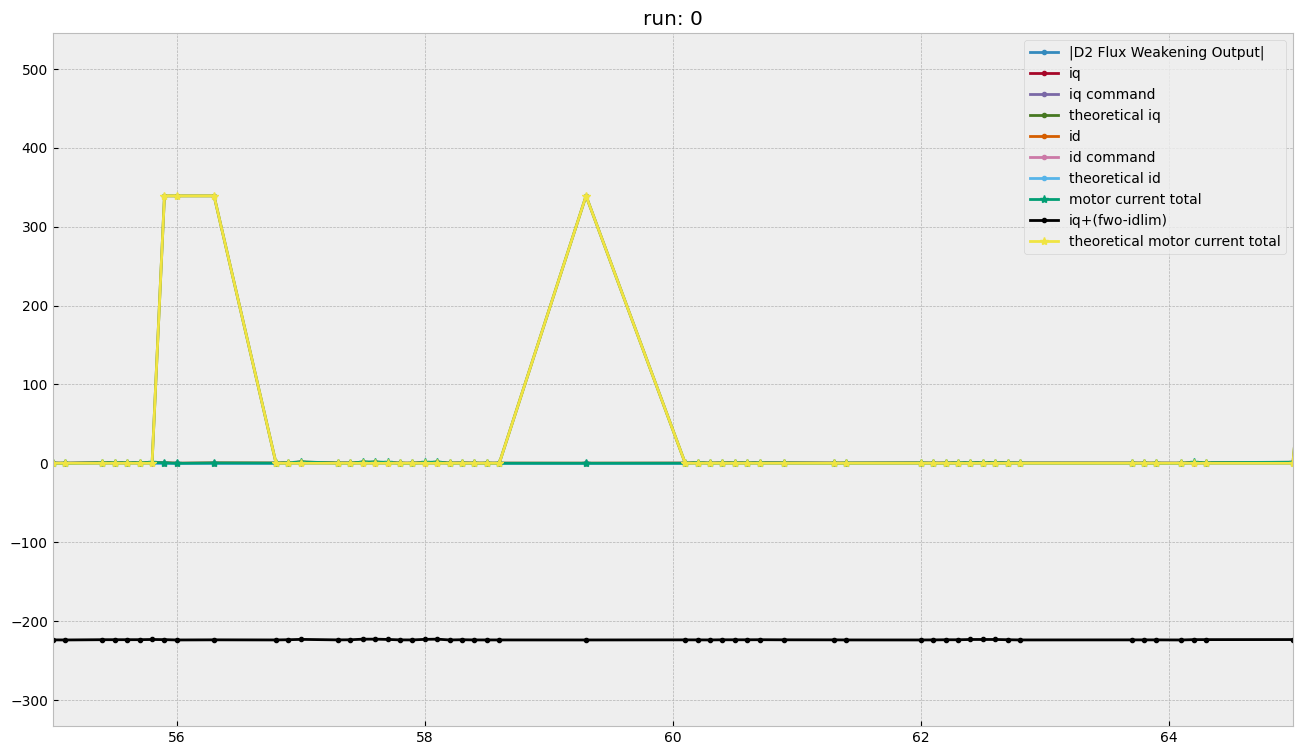

c:\Users\Matthew Samson\source\repos\KS5e-Data-Logging\motor.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  I_d_fw = -self.Fl / self.Ld + (1/self.Ld) * np.sqrt((v_max**2/w_e**2)-(self.Lq*I_q_fw)**2)


0.0


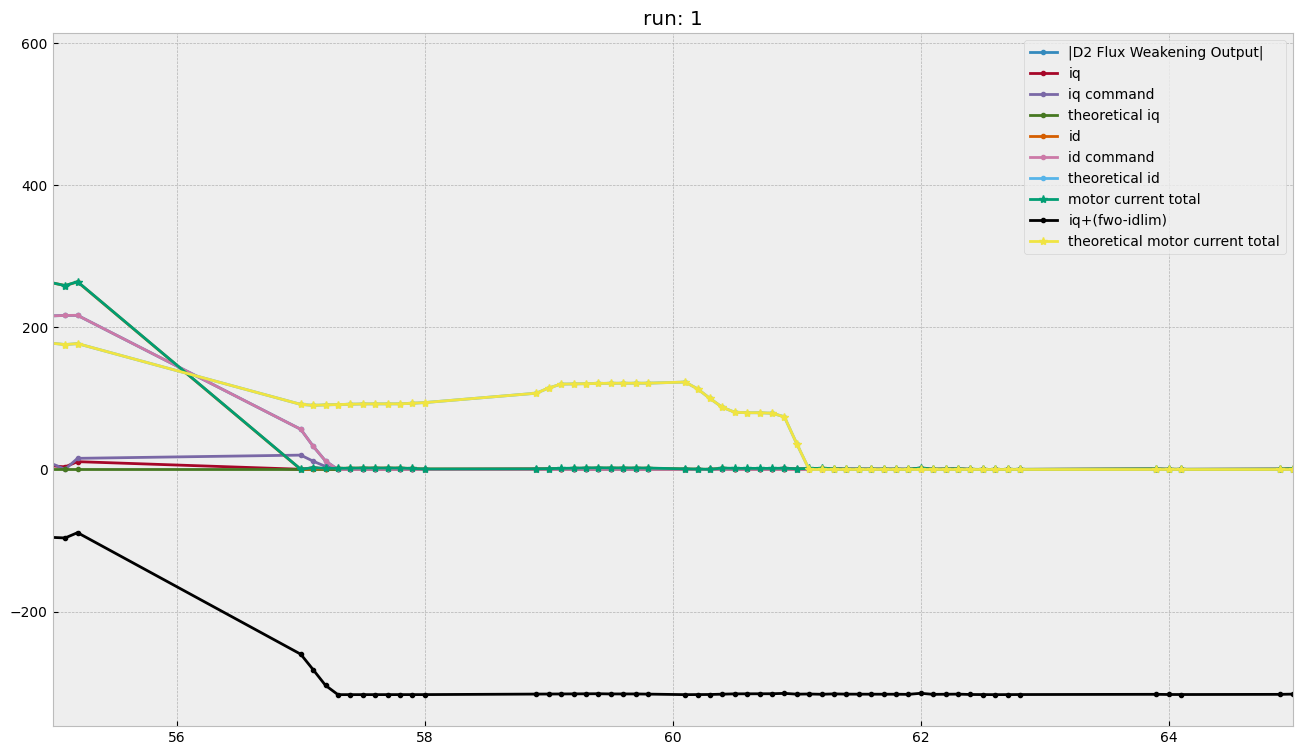

c:\Users\Matthew Samson\source\repos\KS5e-Data-Logging\motor.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  I_d_fw = -self.Fl / self.Ld + (1/self.Ld) * np.sqrt((v_max**2/w_e**2)-(self.Lq*I_q_fw)**2)


0.0


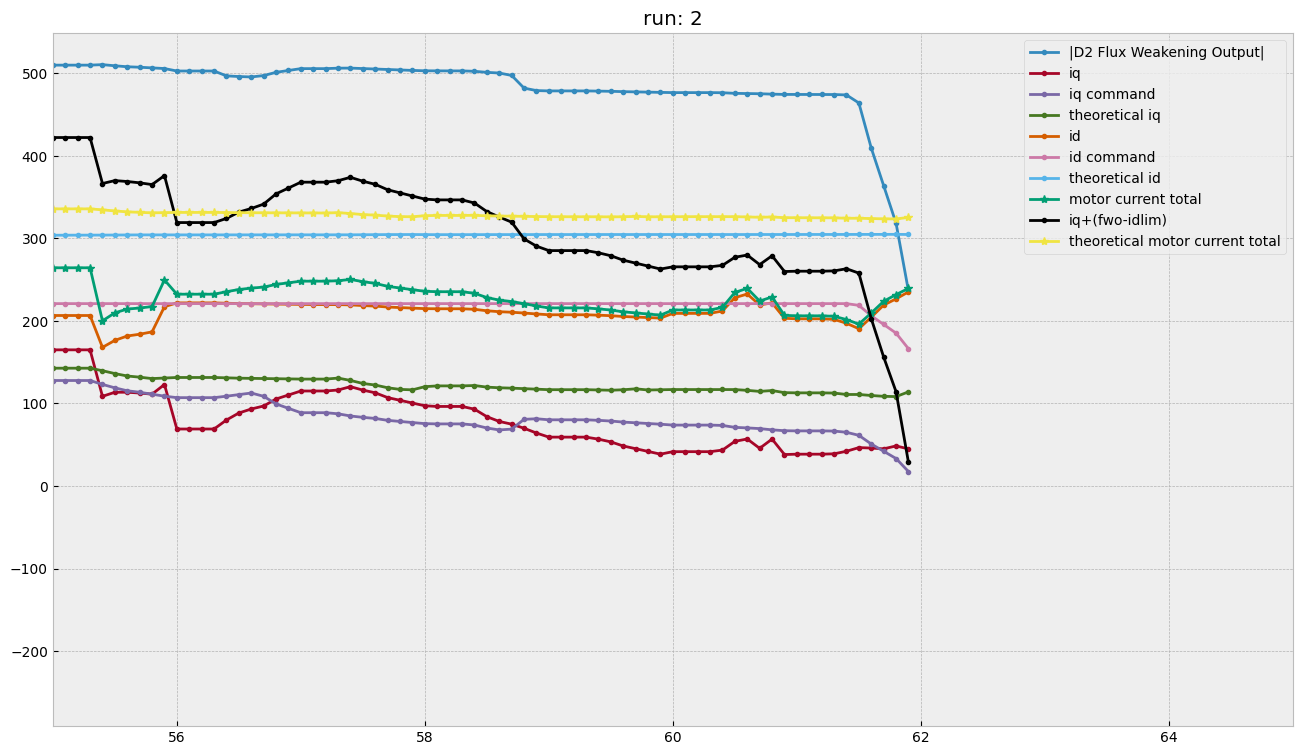

c:\Users\Matthew Samson\source\repos\KS5e-Data-Logging\motor.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  I_d_fw = -self.Fl / self.Ld + (1/self.Ld) * np.sqrt((v_max**2/w_e**2)-(self.Lq*I_q_fw)**2)


0.0


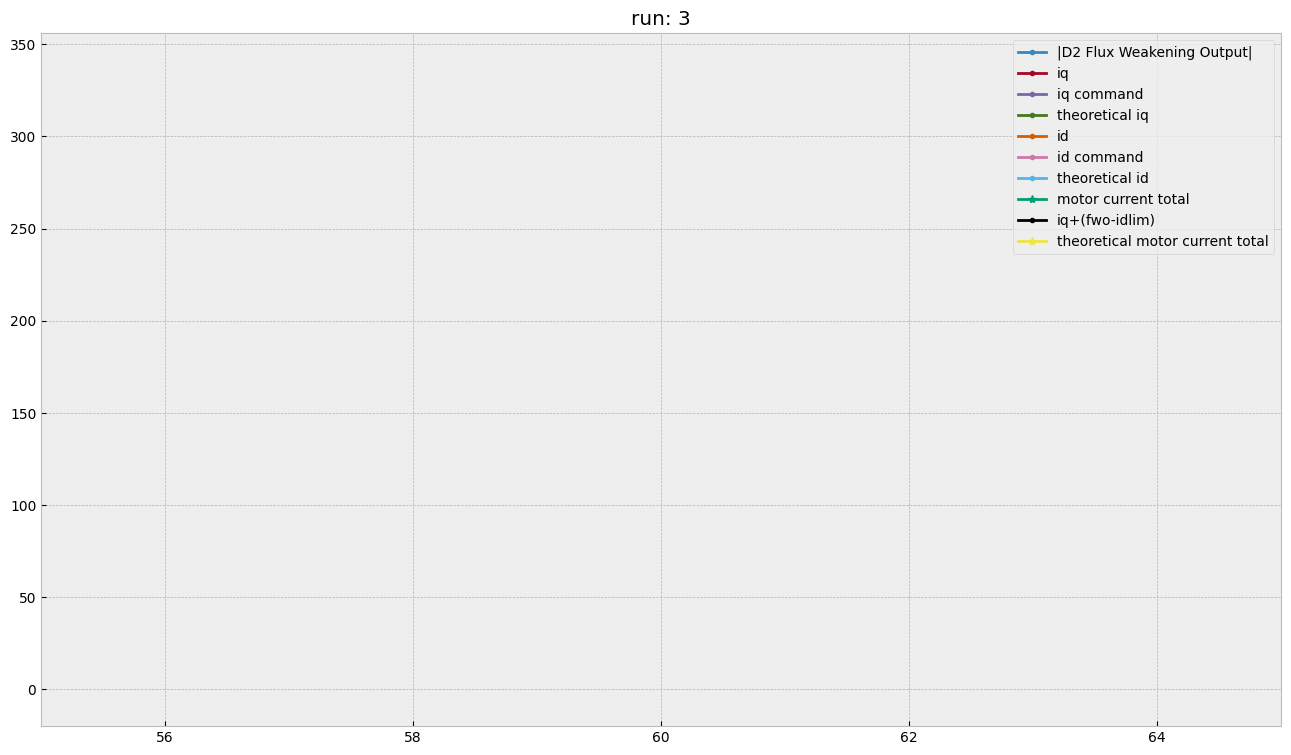

c:\Users\Matthew Samson\source\repos\KS5e-Data-Logging\motor.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  I_d_fw = -self.Fl / self.Ld + (1/self.Ld) * np.sqrt((v_max**2/w_e**2)-(self.Lq*I_q_fw)**2)


0.0375


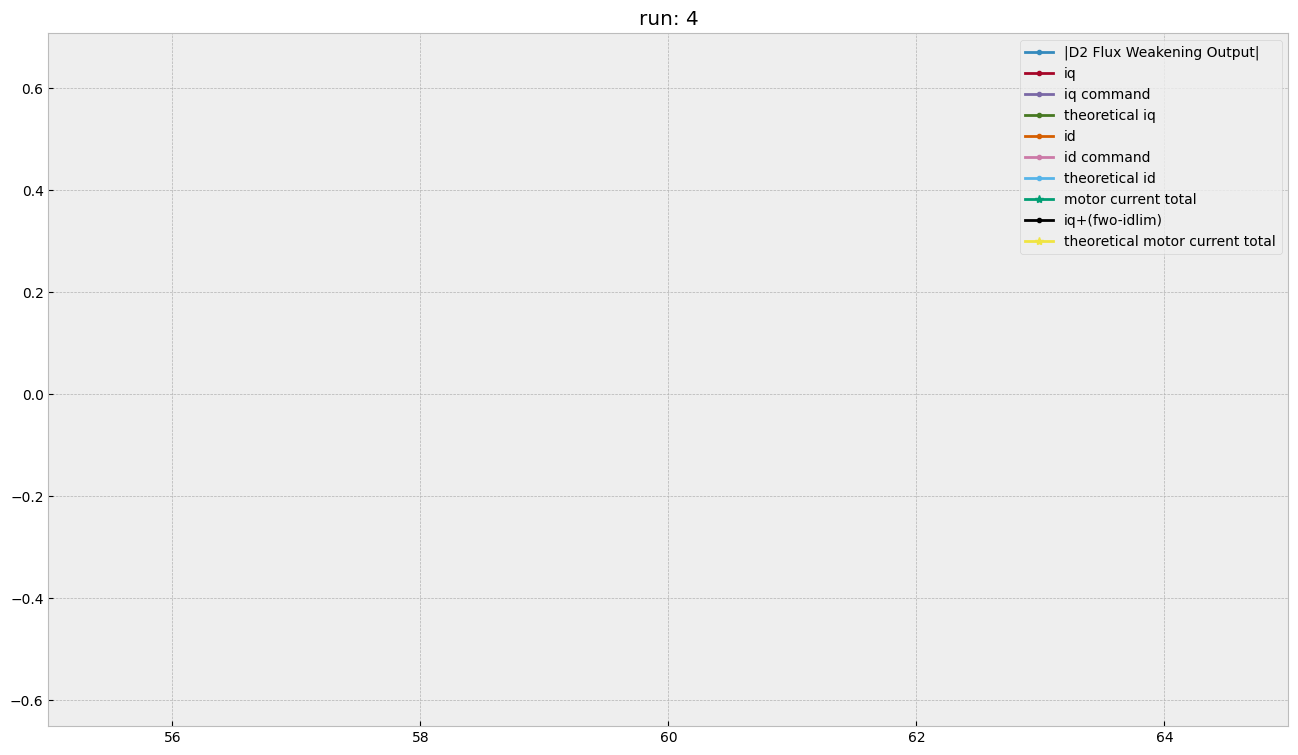

c:\Users\Matthew Samson\source\repos\KS5e-Data-Logging\motor.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  I_d_fw = -self.Fl / self.Ld + (1/self.Ld) * np.sqrt((v_max**2/w_e**2)-(self.Lq*I_q_fw)**2)


0.016129032258064516


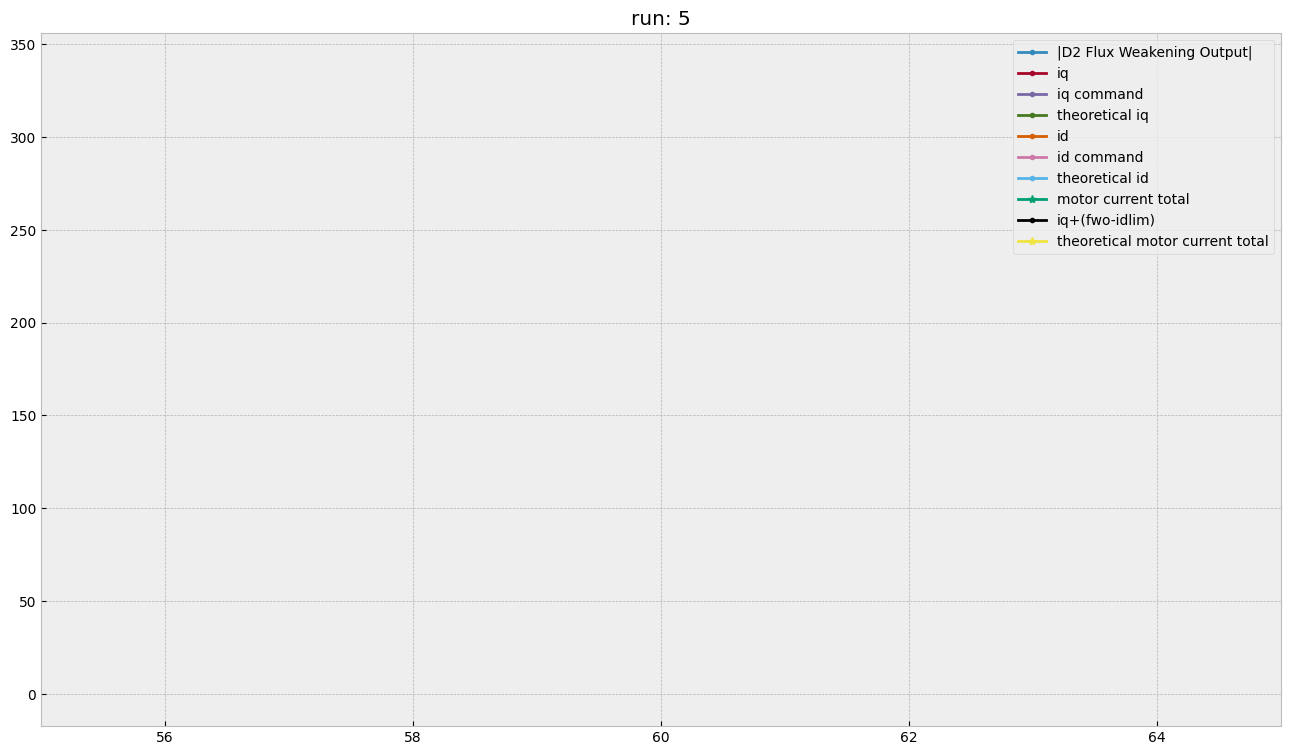

c:\Users\Matthew Samson\source\repos\KS5e-Data-Logging\motor.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  I_d_fw = -self.Fl / self.Ld + (1/self.Ld) * np.sqrt((v_max**2/w_e**2)-(self.Lq*I_q_fw)**2)


0.0


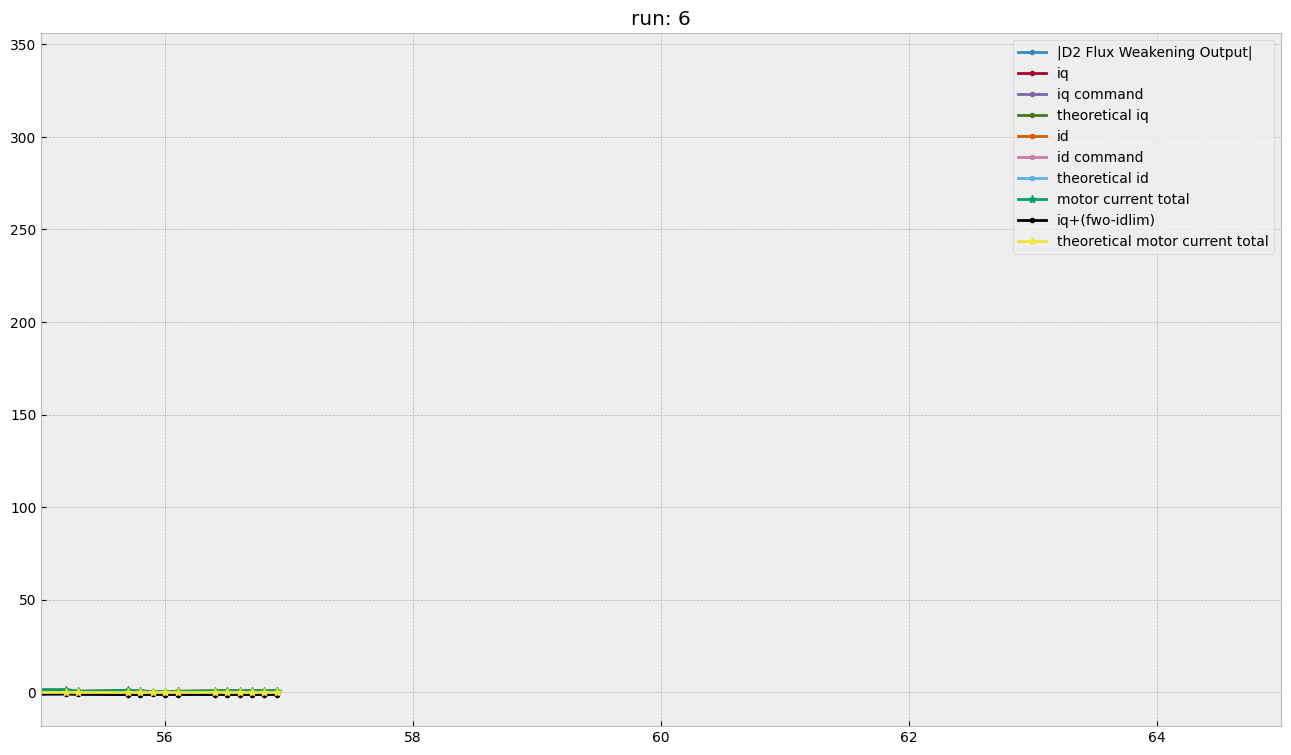

In [11]:


from motor import EMRAX228HV,pdcalcc

for ct, data in testlog.groupby('time_groups'):
    # if data['D1_Commanded_Torque'].max() < 10:
    #     continue
    # if data['D2_Motor_Speed'].min() > 500:
    #     continue
    data['AbsoluteTime'] = (data.index - data.index.min()).total_seconds()
    data.set_index('AbsoluteTime', inplace=True)

    runs_dfs.append(data)
for index,run_data in enumerate(runs_dfs):
    theoretical_id = 'id_t'
    theoretical_iq = 'iq_t'
    theoretical_torque = 't_t'
    theoretical_speed = 'w_t'
    theoretical_vmax= 'v_max'
    motor = EMRAX228HV
    motor.I_dmax=500
    run_data[[theoretical_id,theoretical_iq,theoretical_torque,theoretical_speed,theoretical_vmax]] = run_data.apply(pdcalcc,rpmkey='D2_Motor_Speed',torquekey='D1_Commanded_Torque',voltagekey='D1_DC_Bus_Voltage',motor=motor,axis=1)
    fig = plt.figure(figsize=(16,9))
    # Random output current and total current plot
    id_lim = abs(run_data['D3_Id'].min())
    fwo = abs(run_data['D2_Flux_Weakening_Output'])
    id =abs(run_data['D3_Id'])
    id_command =abs(run_data['D3_Id_Command'])

    iq = run_data['D4_Iq']
    iq_command = run_data['D4_Iq_Command']
    iq_sp = (iq+(fwo-id_lim))
    iq_max_t = 235.0 * math.sqrt(2)
    i= run_data['motor_current']
    plt.plot(run_data.index,fwo,label='|D2 Flux Weakening Output|',marker='.')
    # plt.plot(run_data.index,run_data['motor_current'],label='Motor Current (Iq Id vector magnitude)',marker='.')
    plt.plot(run_data.index,iq,label='iq',marker='.')
    plt.plot(run_data.index,iq_command,label='iq command',marker='.')

    plt.plot(run_data.index,run_data['iq_t'],label='theoretical iq',marker='.')

    plt.plot(run_data.index,id,label='id',marker='.')
    plt.plot(run_data.index,id_command,label='id command',marker='.')

    plt.plot(run_data.index,abs(run_data['id_t']),label='theoretical id',marker='.')

    # plt.plot(run_data.index,id+iq,label='id+iq',marker='.')
    plt.plot(run_data.index,i,label='motor current total',marker='*')
    plt.plot(run_data.index,(iq+(fwo-id_lim)),label='iq+(fwo-idlim)',marker='.',color='black')
    plt.plot(run_data.index,np.sqrt(run_data['iq_t']**2 + run_data['id_t']**2),label='theoretical motor current total',marker='*')
    # plt.ylim((0,320))
    plt.xlim((55,65))
    plt.title(f"run: {index}")
    plt.legend()
    print(id.min())
    plt.show()

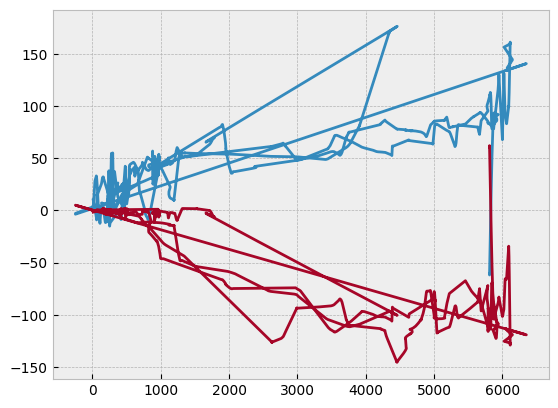

In [12]:
# random vq and vd plot
plt.plot(vehicle_log['smooth_rpm'],vehicle_log['smooth_vq'])
plt.plot(vehicle_log['smooth_rpm'],vehicle_log['smooth_vd'])

In [13]:
# Attempt to sync dyno and car log
dynorun["s"]=pd.to_datetime(dynorun["s"],unit="s")

# this offset has to be manually adjusted lol :(
runoffset = pd.tseries.offsets.DateOffset(milliseconds=0)
# sync them by finding the time where each max occured and aligning those
dynosyncindex = "dyno_kw"
carsyncindex = "acc_kw"
dynomaxindex = dynorun[dynosyncindex].idxmax()

dynomaxtimestamp = (dynorun["s"][dynomaxindex])
carmaxtimestamp = (vehicle_log[carsyncindex].idxmax())
timeoffset = carmaxtimestamp - (dynomaxtimestamp - runoffset)

dynorun["s"] = dynorun["s"]+timeoffset

dynorun

dynomaxindex = dynorun[dynosyncindex].idxmax()

print(dynorun["s"][dynomaxindex])
print(vehicle_log[carsyncindex].idxmax())

2023-04-26 18:13:17.470000
2023-04-26 18:13:17.470000


In [14]:
# get the Xlims of start and end of dyno run (approx)
dynorunduration = dynorun["s"].max() - dynorun["s"].min()
xlimstart = carmaxtimestamp - dynorunduration/2
xlimend = carmaxtimestamp + dynorunduration*2

xlims = (xlimstart,xlimend)
xlims

# attempt to drop data outside of this range
vehicle_log  = vehicle_log[(vehicle_log.index > xlims[0])]
vehicle_log = vehicle_log[(vehicle_log.index < xlims[1])]

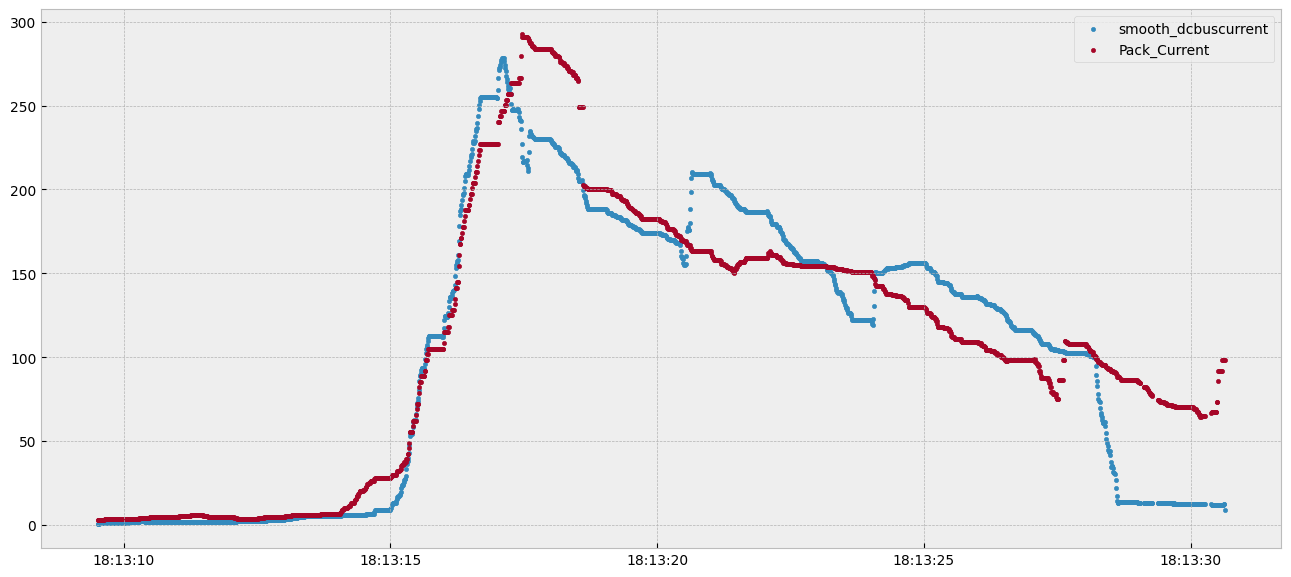

In [15]:
# plot Inverter and BMS current for sanity
plt.figure(figsize=(16,7))
plt.scatter(vehicle_log.index,vehicle_log['smooth_dcbuscurrent'],label='smooth_dcbuscurrent',marker='.')
plt.scatter(vehicle_log.index,vehicle_log['Pack_Current'],label='Pack_Current',marker='.')
plt.legend()
plt.show()

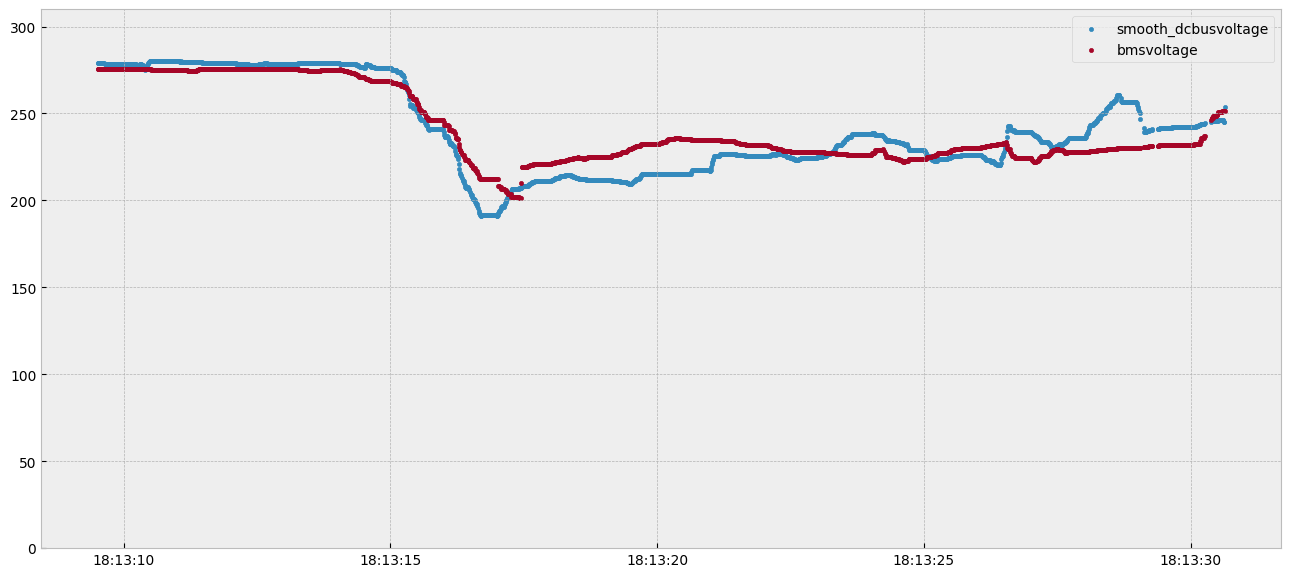

In [16]:
# plot Inverter vs BMS voltage for sanity
plt.figure(figsize=(16,7))
plt.scatter(vehicle_log.index,vehicle_log['smooth_dcbusvoltage'],marker='.',label='smooth_dcbusvoltage')
plt.scatter(vehicle_log.index,vehicle_log['Pack_Inst_Voltage'],marker='.',label='bmsvoltage')
plt.legend()
plt.ylim(0,310)
plt.show()

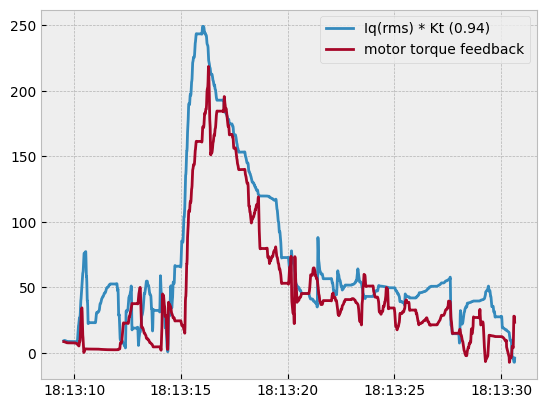

In [17]:
# plot Iq RMS * Kt vs "torque feeback", expect to see tracking well
plt.plot(vehicle_log.index,vehicle_log['calc_motor_torque'],label='Iq(rms) * Kt ('+str(MOTOR_KT)+')')
plt.plot(vehicle_log.index,vehicle_log['smooth_trq'],label='motor torque feedback')
plt.legend()
plt.show()

Column: acc_kw Xmax: 2023-04-26 18:13:17.470000 Ymax: 64.41425542970346 Units: kW
Column: inverter_pwr_kw Xmax: 2023-04-26 18:13:17.100000 Ymax: 54.76351781836399 Units: kW
Column: torque_feedback_pwr_kw Xmax: 2023-04-26 18:13:17.030000 Ymax: 56.60063372502029 Units: kW
Column: motor_power_kt_calc Xmax: 2023-04-26 18:13:17.620000 Ymax: 54.99964482773621 Units: kW


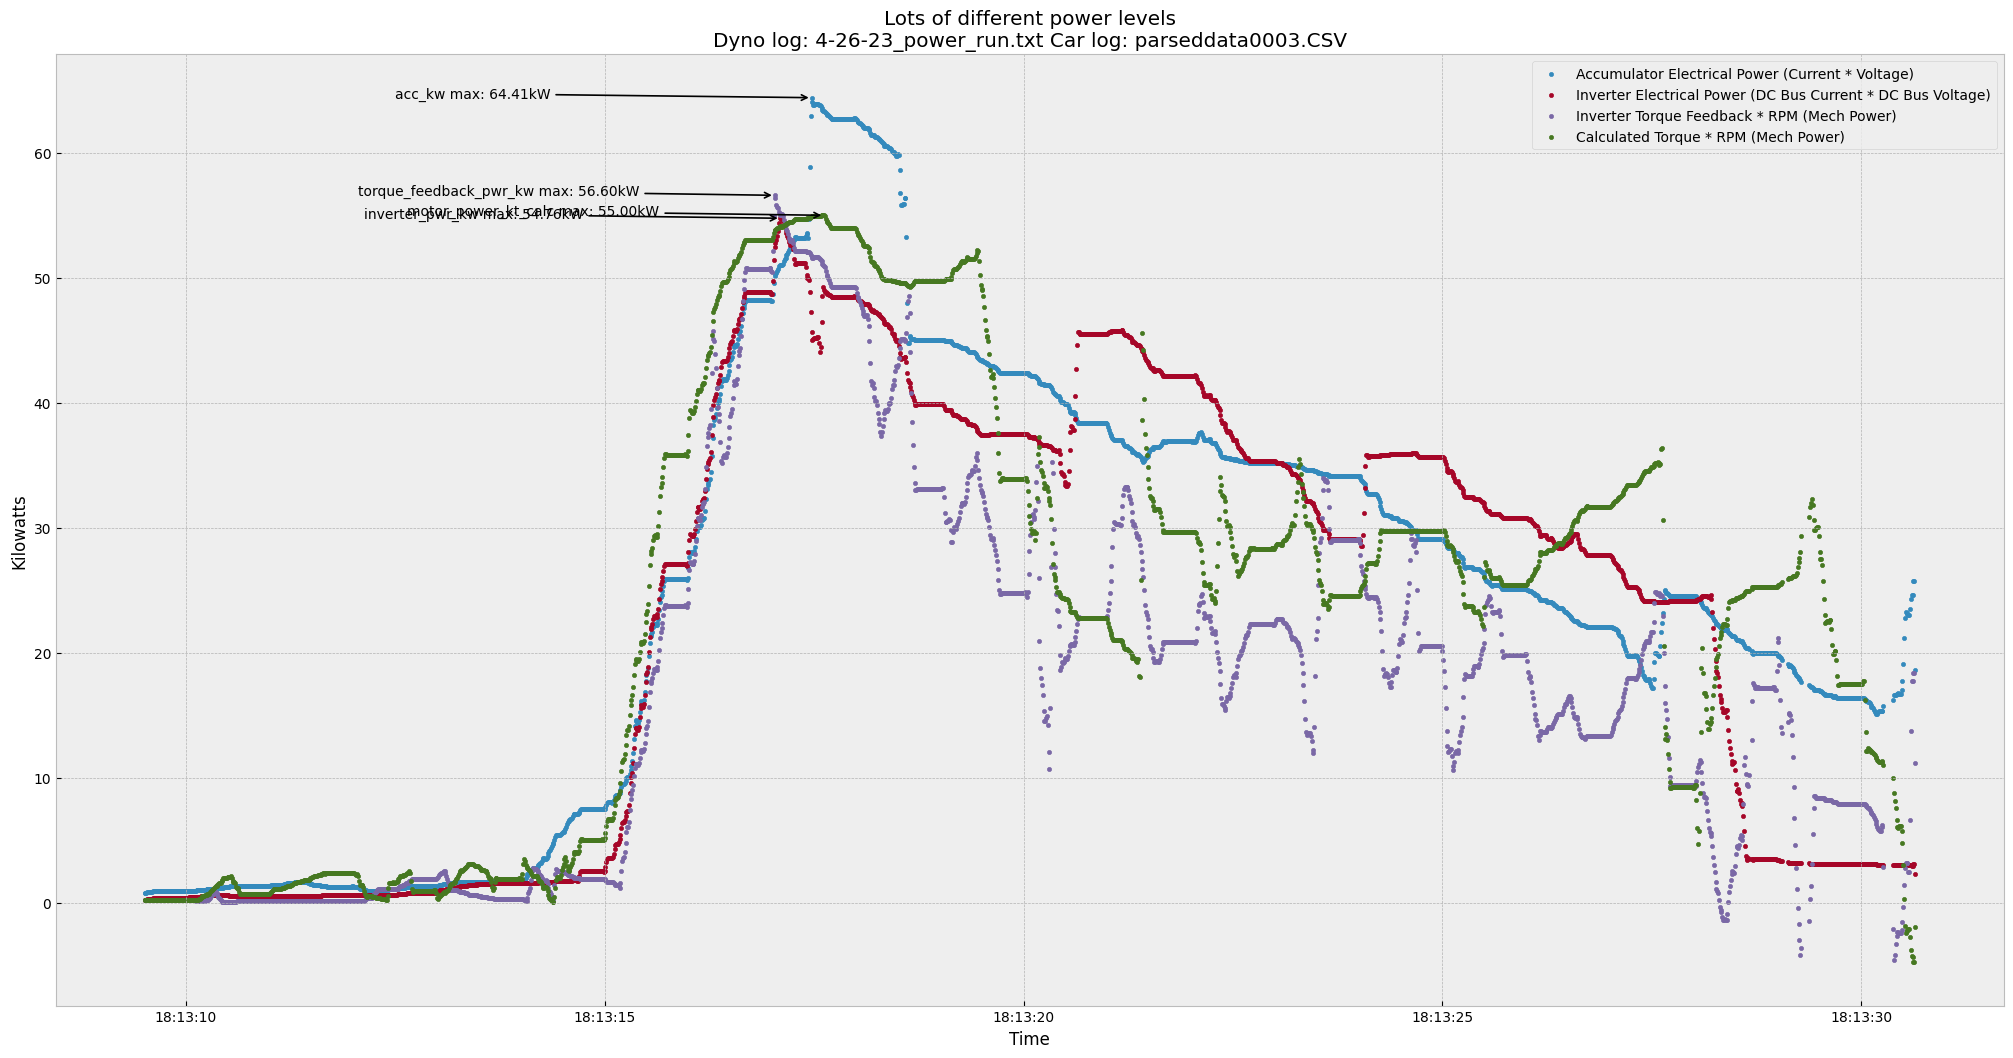

In [18]:
# Attempt to plot motor current, power, etc. etc.
fig,ax = plt.subplots(figsize=(20,10))

# ax.scatter(vehicle_log.index,vehicle_log['chatgpt_power'],label="sqrt(Vq*Iq + Vd*Id) /"+str(power_factor)+"(power factor)",marker='.')
# ax.scatter(vehicle_log.index,(vehicle_log["motor_power"]),marker='.',label="motor current * motor voltage")
# ax.scatter(vehicle_log.index,vehicle_log['evwest_guide_kw']/1000,marker='.',label='(vq * iq + vd * id / power_factor)')
ax.scatter(vehicle_log.index,vehicle_log['acc_kw'],marker='.',label="Accumulator Electrical Power (Current * Voltage)")
ax.scatter(vehicle_log.index,vehicle_log['inverter_pwr_kw'],marker='.',label='Inverter Electrical Power (DC Bus Current * DC Bus Voltage)')
ax.scatter(vehicle_log.index,vehicle_log['torque_feedback_pwr_kw'],marker='.',label='Inverter Torque Feedback * RPM (Mech Power)')
ax.scatter(vehicle_log.index,vehicle_log['motor_power_kt_calc'],marker='.',label='Calculated Torque * RPM (Mech Power)')

# plt.scatter(vehicle_log.index,vehicle_log['motor_current']/10)
filenames=f"\nDyno log: {dynofile} Car log: {carfile}"

def annot_cols(df:DataFrame,cols:list,ax,unit:str,timeindex=None):
    for col in cols:
        xmax = (df[col].idxmax())
        if timeindex:
            xmax = df[timeindex][xmax]
        ymax = df[col].max()
        ax.annotate(
            f"{col} max: {ymax:.2f}{unit}",
            xy=(xmax, ymax), xycoords='data',
            xytext=(-300, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle='->',linewidth=1.2,color='black'))
        print(f"Column: {col} Xmax: {xmax} Ymax: {ymax} Units: {unit}")
        
cols = [
    'acc_kw','inverter_pwr_kw','torque_feedback_pwr_kw','motor_power_kt_calc'
]
annot_cols(vehicle_log,cols,ax,"kW")
plt.tight_layout()
plt.xlabel("Time")
plt.ylabel("Kilowatts")
plt.legend()
plt.title("Lots of different power levels"+filenames)
plt.show()

In [19]:
vehicle_log['D1_Commanded_Torque'].max()

239.9

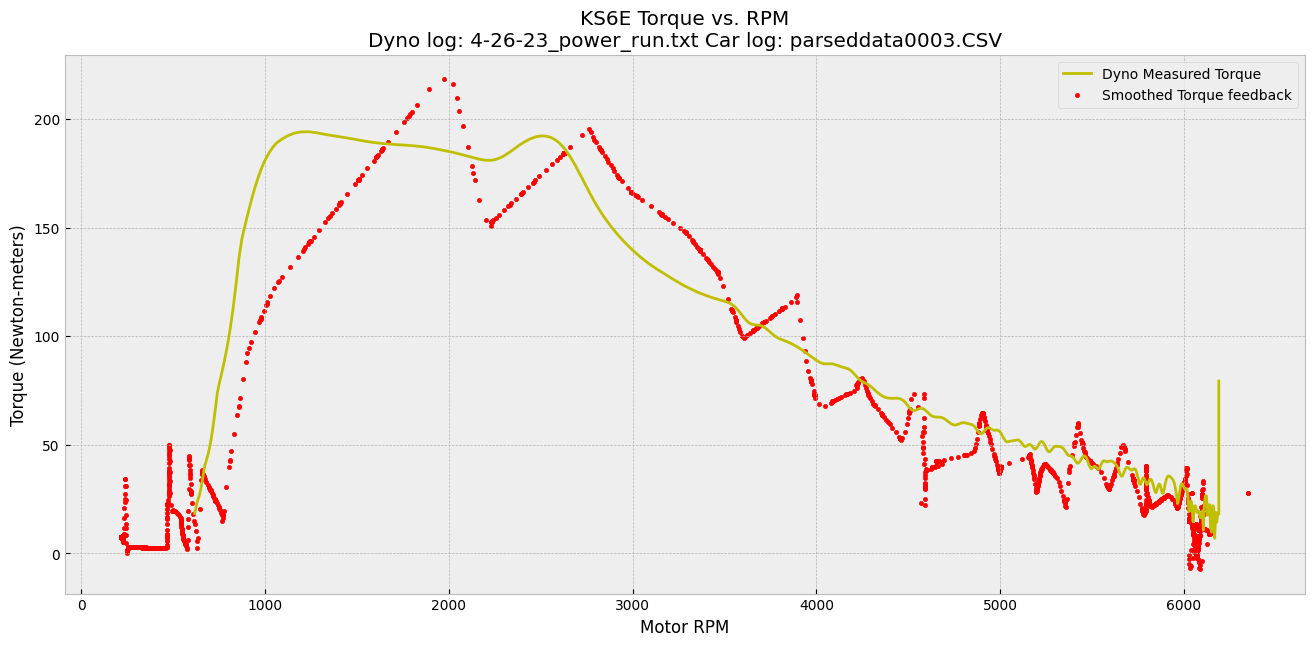

In [20]:
# plot torques and rpms to compare

fig,ax = plt.subplots(figsize=(16,7))
ax.plot(dynorun["motor_rpm"],dynorun["motor_torque"],label="Dyno Measured Torque",color='y')

for dim in tire_dims:
    ax.plot(dynorun["motor_rpm_"+str(dim)],dynorun["motor_torque_"+str(dim)],label="motor_torque_"+str(dim))
        
# ax.scatter(vehicle_log["D2_Motor_Speed"],vehicle_log["D2_Torque_Feedback"],marker='.',color='indigo',label="PM100 Torque Feedback")
ax.scatter(vehicle_log["smooth_rpm"],vehicle_log["smooth_trq"],marker='.',label="Smoothed Torque feedback",c='r')

power_limit = 20 # Kilowatts
vehicle_log['power_limited_torque'] = (power_limit*9548.8/vehicle_log['smooth_rpm'])

# ax.plot(vehicle_log['smooth_rpm'],vehicle_log['power_limited_torque'],label=f"Torque limit based on {power_limit}kW Power Limit",linestyle='-.')
# ax.plot([0,6000],[120,120],label="120Nm",linestyle='-.')
# ax.plot([0,6000],[240,240],label="240Nm",linestyle='-.')

# trqmax = vehicle_log['smooth_trq'].max()
# trqindexmax = vehicle_log['smooth_trq'].idxmax()

# ax.plot([0,vehicle_log['smooth_rpm'][trqindexmax]],[trqmax,trqmax],label=f'{trqmax:.1f}Nm (Max torque actually achieved)',linestyle='-.',color='r')

# ax.scatter(vehicle_log['smooth_rpm'],vehicle_log['smooth_iq'],label='Iq',marker='.')
# ax.scatter(vehicle_log['smooth_rpm'],vehicle_log['smooth_id'].abs(),label='Id',marker='.')
# ax.scatter(vehicle_log['smooth_rpm'],vehicle_log['motor_current'],label='Motor current total',marker='.')
# ax.scatter(vehicle_log['smooth_rpm'],vehicle_log['smooth_dcbusvoltage'],label='DC Bus Voltage',c='pink',marker='.')
# ax.scatter(vehicle_log['smooth_rpm'],vehicle_log['smooth_dcbuscurrent'],label='DC Bus Current',c='lawngreen',marker='.')
# ax.scatter(vehicle_log['smooth_rpm'],vehicle_log['smooth_outputvoltage'],label='Output VOltage',marker='.')
# ax.plot([0,6000],[338,338])
plt.xlabel("Motor RPM")
plt.ylabel("Torque (Newton-meters)")
plt.legend(loc="upper right")
plt.title("KS6E Torque vs. RPM"+filenames)
plt.show()

Column: motor_torque Xmax: 2023-04-26 18:13:16.170000 Ymax: 194.1695048127899 Units: Nm
Column: smooth_trq Xmax: 2023-04-26 18:13:16.290000 Ymax: 218.42515758289886 Units: Nm


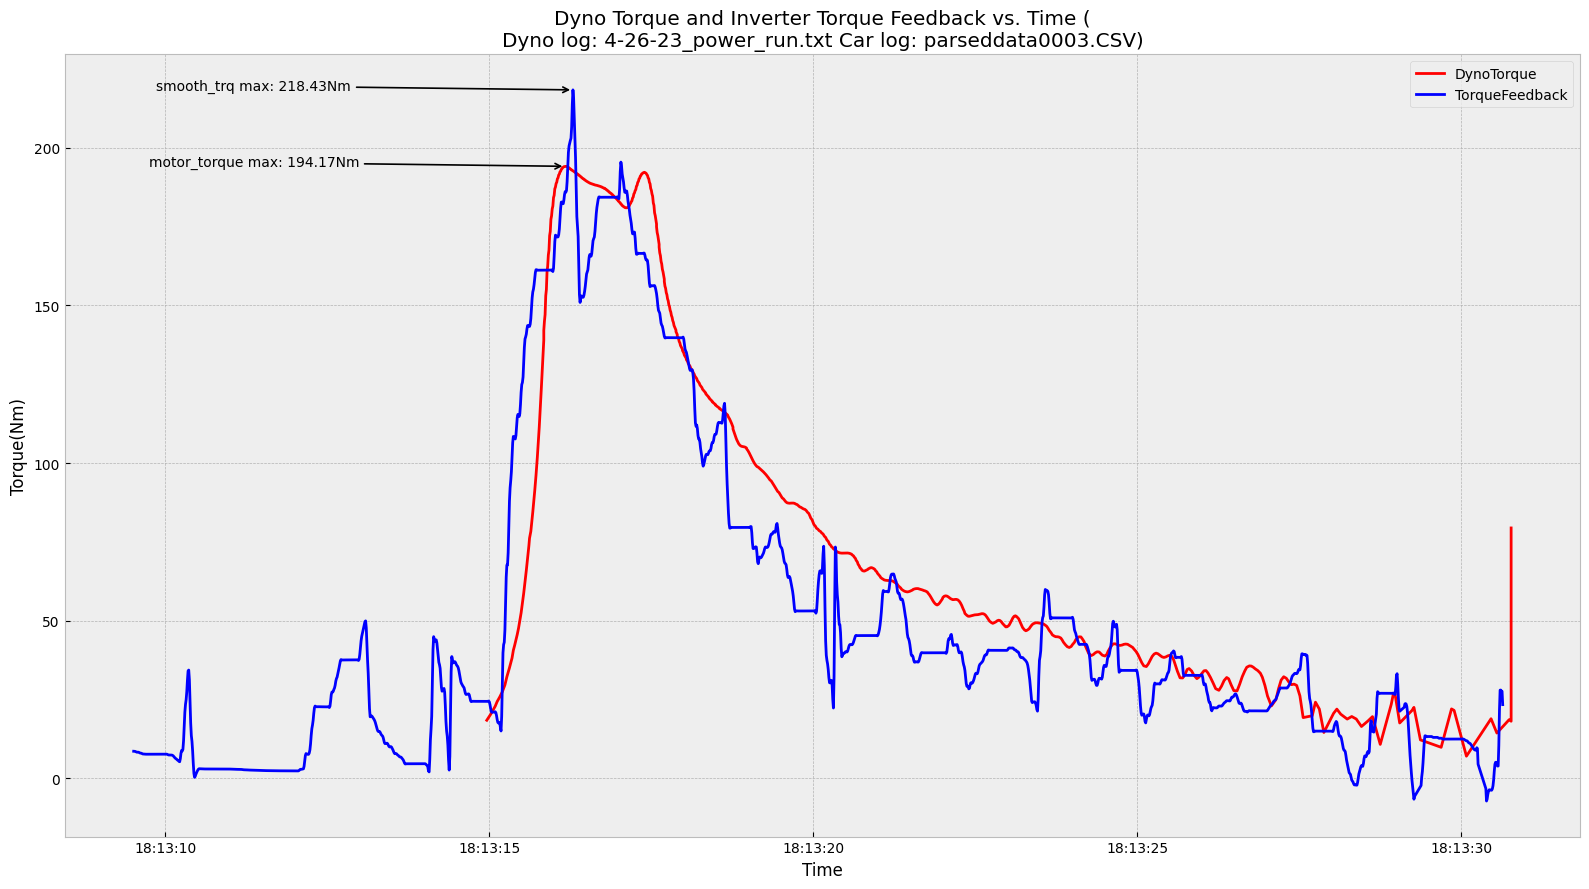

In [21]:
fig,ax = plt.subplots(figsize=(16,9))
ax.plot(dynorun["s"],dynorun['motor_torque'],label="DynoTorque",c="r")
for dim in tire_dims:
    ax.plot(dynorun["s"],dynorun["motor_torque_"+str(dim)],label="dyno measured motor_torque_"+str(dim))
  
ax.plot(vehicle_log.index,vehicle_log['smooth_trq'],label="TorqueFeedback",c="b")
plt.title(f"Dyno Torque and Inverter Torque Feedback vs. Time ({filenames})")
plt.ylabel("Torque(Nm)")
plt.xlabel("Time")

annot_cols(dynorun,["motor_torque"],ax,"Nm",'s')
annot_cols(vehicle_log,["smooth_trq"],ax,"Nm")
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

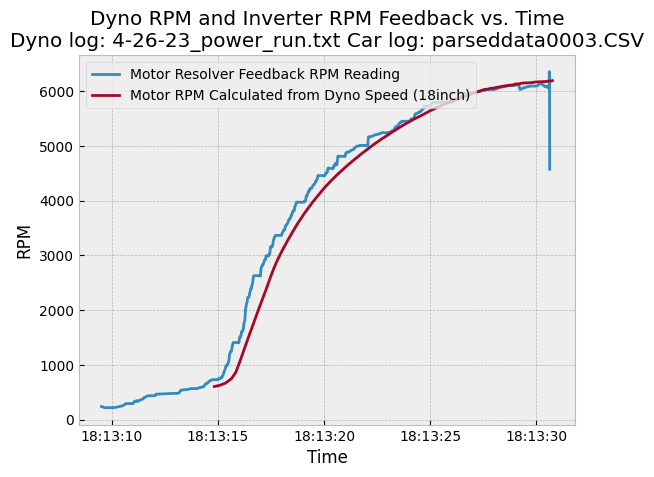

In [22]:
fig = plt.figure()
plt.plot(vehicle_log.index,vehicle_log["smooth_rpm"],label="Motor Resolver Feedback RPM Reading")
plt.plot(dynorun["s"],dynorun["motor_rpm"],label="Motor RPM Calculated from Dyno Speed ("+str(tire_diameter)+"inch)")
for dim in tire_dims:
    plt.plot(dynorun["s"],dynorun["motor_rpm_"+str(dim)],label="Calculated with " + str(dim)+"inch")

plt.title("Dyno RPM and Inverter RPM Feedback vs. Time"+filenames)
plt.ylabel("RPM")
plt.xlabel("Time")

plt.legend(loc='upper left')
plt.show()


In [23]:
# attempt to combine dyno and car dataframes
df = dynorun.set_index('s')
combined_df = vehicle_log.join(df)
combined_df = combined_df.astype(float)
combined_df = resample_data(combined_df,plots_to_compare=False)
combined_df.max()

D1_Commanded_Torque           239.900000
D2_Torque_Feedback            221.551351
D2_Motor_Speed               6150.000000
Pack_Current                  292.900000
Pack_Inst_Voltage             275.695000
D4_Iq                         374.318056
D3_Id                          18.400000
D2_Output_Voltage             160.582090
D3_VAB_Vd_Voltage               0.500000
D4_VBC_Vq_Voltage             160.000000
D1_DC_Bus_Voltage             280.000000
D4_DC_Bus_Current             278.400000
D1_Motor_Angle_Electrical     360.000000
D2_Flux_Weakening_Output        0.000000
kw                             64.174390
smooth_trq                    218.425158
acc_kw                         64.414255
smooth_rpm                   6351.743562
smooth_iq                     374.675618
smooth_id                      17.948541
smooth_outputvoltage          167.402675
smooth_vq                     161.101238
smooth_vd                       0.419827
smooth_dcbusvoltage           280.025681
smooth_dcbuscurr

In [24]:
# calculate power error. rpm
combined_df["acc_power_delta"] = (combined_df["dyno_kw"] - combined_df["acc_kw"]).abs()
combined_df["inv_mech_power_delta"] = (combined_df["dyno_kw"] - combined_df["torque_feedback_pwr_kw"]).abs()

# combined_df['power_error'] = (combined_df["acc_power_delta"] / combined_df['acc_kw'])

# combined_df["power_error"] = ((combined_df["acc_kw"] - combined_df["dyno_kw"]) ** 2).mean() ** .5
combined_df



,D1_Commanded_Torque,D2_Torque_Feedback,D2_Motor_Speed,Pack_Current,Pack_Inst_Voltage,D4_Iq,D3_Id,D2_Output_Voltage,D3_VAB_Vd_Voltage,D4_VBC_Vq_Voltage,...,power_limited_torque,hp,mph,dyno_kw,wheel_rpm,wheel_torque,motor_rpm,motor_torque,acc_power_delta,inv_mech_power_delta
2023-04-26 18:13:09.510,7.522222,8.522222,238.714286,2.902500,275.695,13.964706,2.811765,13.053846,0.269231,13.015385,...,798.791196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-26 18:13:09.520,7.522222,8.522222,238.714286,2.902500,275.695,13.964706,2.811765,13.053846,0.269231,13.015385,...,799.842386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-26 18:13:09.530,7.522222,8.522222,238.714286,2.902500,275.695,13.964706,2.811765,13.053846,0.269231,13.015385,...,802.114291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-26 18:13:09.540,7.611111,8.411111,235.571429,2.974167,275.685,14.383333,3.022222,12.792308,0.161538,12.769231,...,810.312096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-26 18:13:09.550,7.700000,8.300000,232.428571,3.045833,275.675,14.150000,2.666667,12.530769,0.053846,12.523077,...,820.837593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-26 18:13:30.600,63.500000,27.100000,6091.000000,98.254545,251.400,-10.163636,-153.836364,160.582090,-114.361194,134.782090,...,31.583086,6.04,110.1,4.504101,2056.027217,20.918382,6168.081651,6.972794,20.086400,13.191757
2023-04-26 18:13:30.610,63.500000,27.100000,6091.000000,98.254545,251.400,-10.163636,-153.836364,160.582090,-114.361194,134.782090,...,31.583052,6.04,110.1,4.504101,2056.027217,20.918382,6168.081651,6.972794,20.086822,13.193108
2023-04-26 18:13:30.620,63.500000,27.100000,6091.000000,98.254545,251.400,-10.163636,-153.836364,160.582090,-114.361194,134.782090,...,30.066705,6.04,110.1,4.504101,2056.027217,20.918382,6168.081651,6.972794,21.231942,13.846452
2023-04-26 18:13:30.630,63.500000,27.100000,6091.000000,98.254545,251.400,-10.163636,-153.836364,160.582090,-114.361194,134.782090,...,30.066801,6.04,110.1,4.504101,2056.027217,20.918382,6168.081651,6.972794,21.231785,13.840285


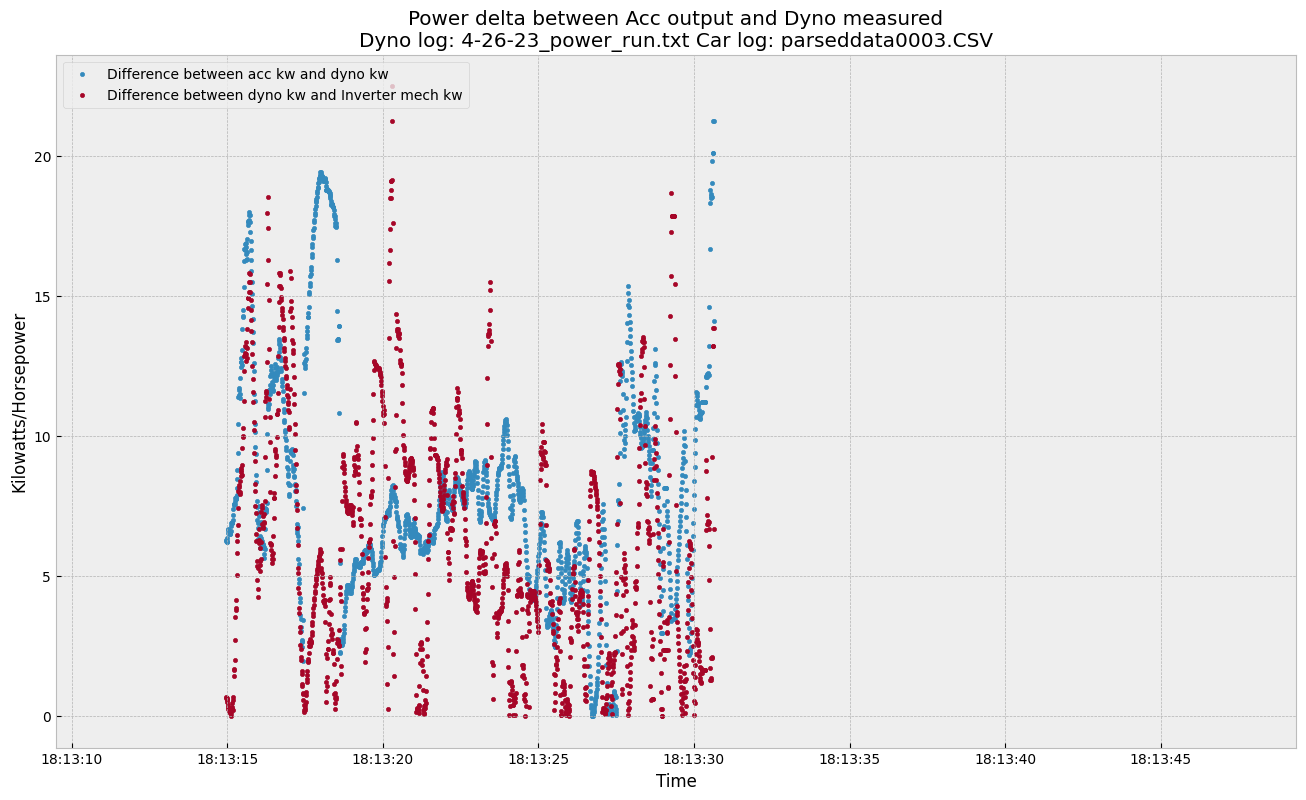

In [25]:
fig = plt.figure(figsize=(16, 9))
plt.scatter(combined_df.index,combined_df['acc_power_delta'],label='Difference between acc kw and dyno kw',marker='.')
# plt.scatter(combined_df.index,combined_df['acc_power_delta']*1.341,label='Delta Horsies',marker='.')

plt.scatter(combined_df.index,combined_df['inv_mech_power_delta'],label='Difference between dyno kw and Inverter mech kw',marker='.')
# plt.scatter(combined_df.index,combined_df['inv_mech_power_delta']*1.341,label='Inv Delta Horsies',marker='.')

# plt.scatter(combined_df.index,combined_df['power_error'],label='Smoothed Acc Power',marker='.')

plt.ylabel("Kilowatts/Horsepower")
plt.xlabel("Time")
plt.xlim(xlims)
# plt.ylim((-1,40))

plt.title("Power delta between Acc output and Dyno measured"+filenames)
plt.legend(loc="upper left")
plt.show()

Column: acc_kw Xmax: 2023-04-26 18:13:17.470000 Ymax: 64.41425542970346 Units: kW
Column: torque_feedback_pwr_kw Xmax: 2023-04-26 18:13:17.030000 Ymax: 56.60063372502029 Units: kW
Column: inverter_pwr_kw Xmax: 2023-04-26 18:13:17.100000 Ymax: 54.76351781836399 Units: kW
Column: dyno_kw Xmax: 2023-04-26 18:13:17.470000 Ymax: 51.4765100671141 Units: kW


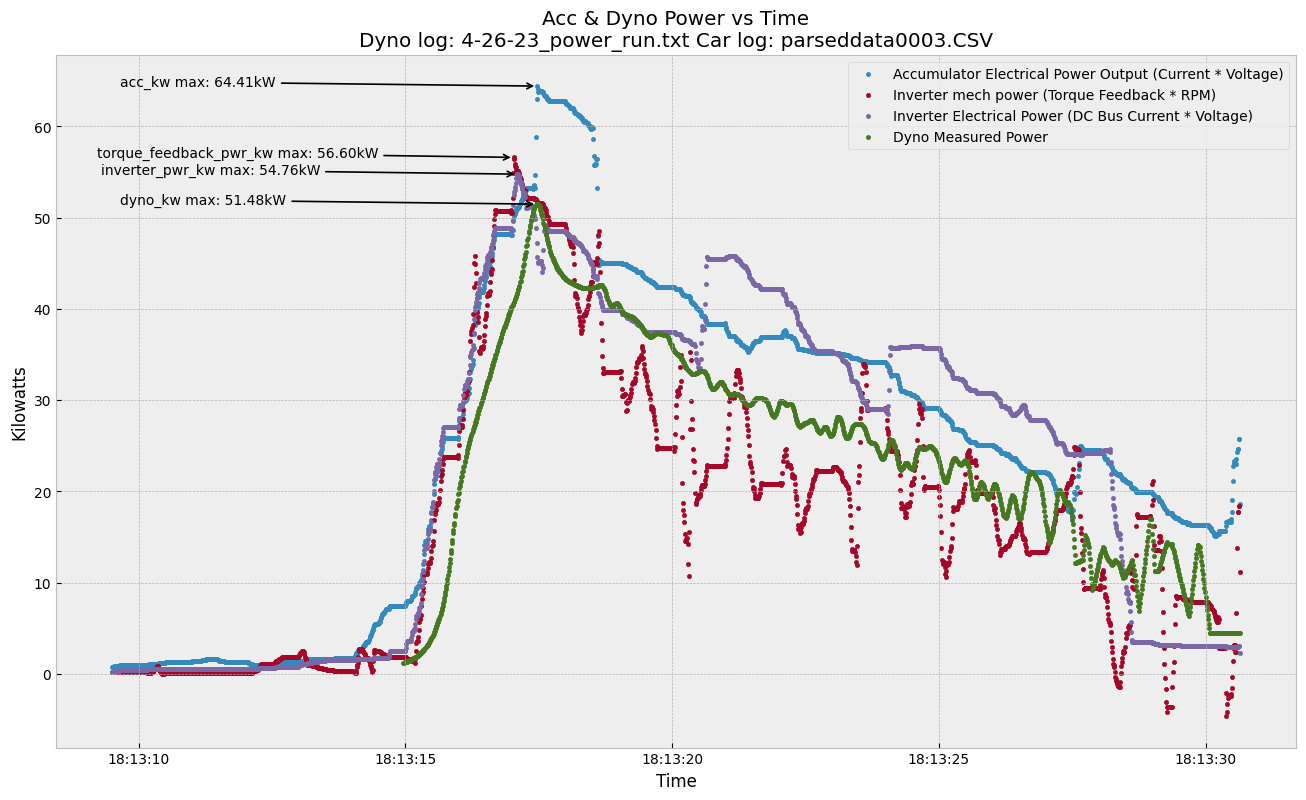

In [26]:
fig, ax = plt.subplots(figsize=(16,9))

ax.scatter(combined_df.index,combined_df['acc_kw'],label='Accumulator Electrical Power Output (Current * Voltage)',marker='.')
ax.scatter(combined_df.index,combined_df['torque_feedback_pwr_kw'],marker='.',label='Inverter mech power (Torque Feedback * RPM)')
# ax.scatter(combined_df.index,combined_df['motor_power_kt_calc'],marker='.',label='Calc mech power (calc Torque  * RPM)')
ax.scatter(combined_df.index,combined_df['inverter_pwr_kw'],marker='.',label='Inverter Electrical Power (DC Bus Current * Voltage)')
ax.scatter(combined_df.index,combined_df['dyno_kw'],label='Dyno Measured Power',marker='.')
ax.set_ylabel("Kilowatts")
ax.set_xlabel("Time")

cols = [
    'acc_kw','torque_feedback_pwr_kw','inverter_pwr_kw','dyno_kw'
]
annot_cols(combined_df,cols,ax,"kW")

plt.title("Acc & Dyno Power vs Time"+filenames)
plt.legend(loc="upper right")
plt.show()

In [27]:
def calculate_efficiency(input_value, output_value):
    # print(f"In: {input_value:.2f} Out: {output_value:.2f}")
    efficiency = (output_value / input_value)
    # print(f"Efficiency {efficiency*100:.2f}%")
    return efficiency
acc_pwr_max = combined_df['acc_kw'].max()
motor_pwr_max = combined_df['torque_feedback_pwr_kw'].max()
dyno_pwr_max = combined_df['dyno_kw'].max()
stage1eff = calculate_efficiency(acc_pwr_max,motor_pwr_max)
stage2eff = calculate_efficiency(motor_pwr_max,dyno_pwr_max)
print("Assuming all peak power were hit at the same point")
print(f"Acc power max: \n\t{acc_pwr_max:.2f}kW\nMotor power max: \n\t{motor_pwr_max:.2f}kW\nDyno power max: \n\t{dyno_pwr_max:.2f}kW")
print(f"Acc to motor efficiency: \n\t{stage1eff*100:.2f}%")
print(f"Motor to dyno efficiency: \n\t{stage2eff*100:.2f}%")
print(f"Total efficiency \n\t{stage1eff*stage2eff*100}%")

Assuming all peak power were hit at the same point
Acc power max: 
	64.41kW
Motor power max: 
	56.60kW
Dyno power max: 
	51.48kW
Acc to motor efficiency: 
	87.87%
Motor to dyno efficiency: 
	90.95%
Total efficiency 
	79.91477930423558%


In [28]:
# Estimating a dyno error factor
expected_motor_to_wheels_efficiency = 0.95 # What we expect the drivetrain loss to be
# Do we factor in powerloss from tires? Is that a thing?
expected_dyno_pwr_max = expected_motor_to_wheels_efficiency * motor_pwr_max
dyno_error_kw = expected_dyno_pwr_max-dyno_pwr_max
dyno_error_kw
print(f"Dyno highest power reading: \n\t{dyno_pwr_max:.2f}kW")
print(f"Expected power reading with {expected_motor_to_wheels_efficiency*100}% drivetrain efficiency: \n\t{expected_dyno_pwr_max:.2f}kW")
print(f"Error of dyno: \n\t{dyno_error_kw:.2f}kW")
print(f"In horsepower: \n\t{dyno_error_kw*1.341:.2f}HP")

Dyno highest power reading: 
	51.48kW
Expected power reading with 95.0% drivetrain efficiency: 
	53.77kW
Error of dyno: 
	2.29kW
In horsepower: 
	3.08HP
